In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from pycaret.regression import *

TRAIN_PATH = "../train.csv"
TRAIN_CLEANED_PATH = "../cleaned/train_clean_Vbiyu.csv"
TEST_PATH = "../../datasets/test.csv"
SAMPLE_SUBMISSION_PATH = "../../datasets/sample_submission.csv"

warnings.filterwarnings("ignore")

In [36]:
train = pd.read_csv(TRAIN_CLEANED_PATH, delimiter=',')
train.head()

,datetime_iso,temp,visibility,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds,year,month
0,1979-01-01 00:00:00+00:00,24.75,gatau,23.89,25.76,24.28,25.22,1012.0,95.0,0.82,320.0,0.00,0.0,-1.0,-1.0,100.0,1979,1
1,1979-01-01 01:00:00+00:00,24.58,gatau,23.73,25.57,23.99,25.26,1012.0,95.0,0.96,338.0,0.00,0.0,0.0,0.0,100.0,1979,1
2,1979-01-01 02:00:00+00:00,26.60,gatau,24.06,26.60,26.10,27.39,1012.0,86.0,1.22,339.0,0.00,0.0,-1.0,-1.0,99.0,1979,1
3,1979-01-01 03:00:00+00:00,27.31,gatau,24.37,30.90,26.59,28.36,1012.0,84.0,1.08,342.0,0.13,0.0,0.0,-1.0,94.0,1979,1
4,1979-01-01 04:00:00+00:00,27.41,gatau,25.05,31.54,26.58,28.31,1011.0,87.0,0.86,336.0,0.34,0.0,-1.0,0.0,100.0,1979,1


In [37]:
train.drop(columns=["datetime_iso"], inplace=True)

In [38]:
train["musim"] = train["month"]

# 0 penghujan, 1 kemarau
train["musim"] = train["musim"].apply(lambda x: 0 if x > 9 or x <= 5 else 1)

In [39]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_ohe = ohe.fit_transform(train[["visibility"]])
X_ohe_df = pd.DataFrame(X_ohe, columns=ohe.get_feature_names_out())

X = pd.concat([train, X_ohe_df], axis=1).drop(columns=["rain_1h", "visibility"])
y = train["rain_1h"]

In [40]:
# X.drop(columns=["year"], inplace=True)

In [41]:
from sklearn.preprocessing import RobustScaler

X_cols = list(X.columns)
numeric_col = [item for item in X_cols if item not in ['rain_3h', 'snow_1h', 'snow_3h',
                                                       'visibility_-1', 'visibility_-1000', 'visibility_gatau', 'month', 'musim']]

robustscaler = RobustScaler()
X[numeric_col] = robustscaler.fit_transform(X[numeric_col])

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
# cb = CatBoostRegressor(verbose=False)

# cb.fit(X_train, y_train)
# y_pred = cb.predict(X_test)

# MSE = mean_squared_error(y_test, y_pred)

# print("RMSE: ", np.sqrt(MSE))

In [33]:
s = setup(
    pd.concat([X, y], axis=1), 
    target='rain_1h', 
    session_id=123, 
    remove_outliers=True,
    outliers_method='ee',
    # feature_selection=True,
    remove_multicollinearity=True,
    use_gpu=True
)

,Description,Value
0,Session id,123
1,Target,rain_1h
2,Target type,Regression
3,Original data shape,"(341880, 20)"
4,Transformed data shape,"(329914, 20)"
5,Transformed train set shape,"(227349, 20)"
6,Transformed test set shape,"(102565, 20)"
7,Numeric features,19
8,Preprocess,True
9,Imputation type,simple


In [13]:
best = compare_models(
    sort='RMSE',
    include=['catboost', 'xgboost', 'lightgbm']
)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.4425,0.7646,0.8742,0.1618,0.3637,1.2234,22.5680
lightgbm,Light Gradient Boosting Machine,0.4424,0.7709,0.8777,0.1549,0.3638,1.1778,1.6100
xgboost,Extreme Gradient Boosting,0.4615,0.8133,0.9015,0.1079,0.3791,1.3022,1.1430


In [53]:
lgbm = create_model('lightgbm')
tuned_lgbm = tune_model(lgbm, n_iter=10, optimize='RMSE',
                        choose_better=True, search_library='optuna')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4542,0.8679,0.9316,0.1580,0.3690,1.1892
1,0.4333,0.7319,0.8555,0.1510,0.3583,1.1770
2,0.4455,0.7875,0.8874,0.1504,0.3650,1.1815
3,0.4464,0.7991,0.8939,0.1523,0.3664,1.1488
4,0.4415,0.7637,0.8739,0.1622,0.3620,1.1615
5,0.4435,0.7510,0.8666,0.1538,0.3650,1.1868
6,0.4327,0.7357,0.8577,0.1546,0.3594,1.1927
7,0.4407,0.7600,0.8718,0.1597,0.3629,1.1957
8,0.4406,0.7543,0.8685,0.1577,0.3626,1.1880


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4519,0.8649,0.9300,0.1609,0.3702,1.2341
1,0.4301,0.7274,0.8529,0.1562,0.3592,1.2253
2,0.4447,0.7817,0.8842,0.1567,0.3667,1.2210
3,0.4461,0.7977,0.8931,0.1539,0.3682,1.2138
4,0.4397,0.7636,0.8739,0.1623,0.3632,1.2115
5,0.4354,0.7412,0.8609,0.1648,0.3628,1.2105
6,0.4305,0.7365,0.8582,0.1536,0.3597,1.2393
7,0.4401,0.7581,0.8707,0.1618,0.3648,1.2470
8,0.4396,0.7499,0.8660,0.1626,0.3643,1.2401


[I 2023-09-03 22:54:17,715] Searching the best hyperparameters using 239315 samples...
[I 2023-09-03 22:55:48,005] Finished hyperparemeter search!


In [45]:
tuned_lgbm = finalize_model(tuned_lgbm)

In [44]:
def preprocess(df):
    df.drop(columns=["datetime"], inplace=True)

    # datetime_iso
    df["year"] = df["datetime_iso"].str.split(
        "-", expand=True)[0]
    df["month"] = df["datetime_iso"].str.split(
        "-", expand=True)[1]
    
    # time-zone
    df.drop(columns=["time-zone"], inplace=True)

    # temp
    df["temp"] = df["temp"].replace({
        "Celcius": "",
        "C": "",
        "°": ""
    }, regex=True).str.strip().astype("float")

    # visibility
    df["visibility"] = df["visibility"].replace({
        "-1km": "-1000",
        "-1 km": "-1000",
        "unrecognized": "gatau",
        "unknown": "gatau",
        "unidentified": "gatau",
        "undefined": "gatau",
        "missing": "gatau",
        "empty": "gatau",
        "m": "",
    }, regex=True).str.strip().fillna("gatau").replace({
        "": "gatau"
    })
    
    # d_point
    df["d_point"] = df["d_point"].replace({
        "Celcius": "",
        "C": "",
        "°": ""
    }, regex=True).str.strip().astype("float")


    # feels
    df["feels"] = df["feels"].replace({
        "Celcius": "",
        "C": "",
        "°": ""
    }, regex=True).str.strip().astype("float")


    # min_temp
    df["min_temp"] = df["min_temp"].replace({
        "Celcius": "",
        "C": "",
        "°": ""
    }, regex=True).str.strip().astype("float")

    # max_temp
    df["max_temp"] = df["max_temp"].replace({
        "Celcius": "",
        "C": "",
        "°": ""
    }, regex=True).str.strip().astype("float")


    # prssr
    df["prssr"] = df["prssr"].replace({
        "hPa": "",
        r"\s.": ""
    }, regex=True).str.strip().astype("float")
    
    # sea_level -> jujur ini maksudnya apaan coba, gaada semua. -1 hPa itu keknya maksudnya gaada data? sementara hapus aja dulu
    df["sea_level"].value_counts(),
    df["grnd_level"].value_counts()

    df.drop(columns=["sea_level", "grnd_level"], inplace=True)
    
    # hum
    df["hum"] = df["hum"].replace({
        "%": ""
    }, regex=True).str.strip().astype("float")
    
    # wind_spd
    df["wind_spd"] = df["wind_spd"].replace({
        "m/s": ""
    }, regex=True).str.strip().astype("float")


    # wind_deg
    df["wind_deg"] = df["wind_deg"].replace({
        "°": ""
    }, regex=True).str.strip().astype("float")
    
    # rain_3h -> 0 artinya ga hujan, -1 artinya no inpo
    df["rain_3h"] = df["rain_3h"].replace({
        "milimeter": "",
        "mm": "",
        "no-rain": "0",
        "volume:0": "0",
        "nol": "0",
        "no_rain": "0",
        "volume:zero": "0",
        "zero": "0",
    }, regex=True).str.strip().fillna("-1").astype(float)


    # snow_1h
    df["snow_1h"] = df["snow_1h"].replace({
        "milimeter": "",
        "mm": "",
        "no-snow": "0",
        "volume:0": "0",
        "nol": "0",
        "no_snow": "0",
        "volume:zero": "0",
        "zero": "0",
    }, regex=True).str.strip().fillna("-1").astype(float)
    
    # snow_3h
    df["snow_3h"] = df["snow_3h"].replace({
        "milimeter": "",
        "mm": "",
        "no-snow": "0",
        "volume:0": "0",
        "nol": "0",
        "no_snow": "0",
        "volume:zero": "0",
        "zero": "0",
    }, regex=True).str.strip().fillna("-1").astype(float)

        # clouds
    df["clouds"] = df["clouds"].replace({
        "%": ""
    },regex=True).str.strip().astype(float)
    
    df.drop(columns=["datetime_iso"], inplace=True)

    df["musim"] = df["month"].astype("int")
    # 0 penghujan, 1 kemarau
    df["musim"] = df["musim"].apply(lambda x: 0 if x > 9 or x <= 5 else 1)

    X_ohe = ohe.transform(df[["visibility"]])
    X_ohe_df = pd.DataFrame(X_ohe, columns=ohe.get_feature_names_out())


    X = pd.concat([df, X_ohe_df], axis=1).drop(
        columns=["visibility"])
    X[numeric_col] = robustscaler.transform(X[numeric_col])

    return X

In [48]:
test = pd.read_csv(TEST_PATH)
test_clean = preprocess(test)

test_clean.head()

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_3h,snow_1h,snow_3h,clouds,year,month,musim,visibility_-1,visibility_-1000,visibility_gatau
0,0.114370,-0.705426,-0.008130,0.159292,-0.032934,-0.5,-0.615385,0.195652,1.169231,0.0,-1.0,0.0,0.000000,1.0,01,0,0.0,0.0,1.0
1,0.090909,0.271318,-0.018970,0.171091,0.230539,-0.5,-0.076923,0.434783,1.138462,0.0,0.0,0.0,-0.105263,1.0,01,0,0.0,0.0,1.0
2,0.727273,0.883721,1.088076,0.752212,0.607784,-0.5,-0.615385,0.489130,1.092308,0.0,0.0,0.0,-0.368421,1.0,01,0,0.0,0.0,1.0
3,0.774194,0.527132,1.065041,0.896755,0.541916,-1.0,-0.846154,0.239130,1.046154,0.0,0.0,-1.0,-0.315789,1.0,01,0,0.0,0.0,1.0
4,1.041056,0.038760,1.182927,1.129794,0.988024,-1.5,-1.384615,0.130435,1.046154,-1.0,0.0,0.0,-0.052632,1.0,01,0,0.0,0.0,1.0


In [55]:
pred = tuned_lgbm.predict(X_test)

np.sqrt(mean_squared_error(y_test, pred))

0.8066464954059243

In [51]:
pred_submission = tuned_lgbm.predict(test_clean)
submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)

submission["rain_1h"] = pred_submission

In [52]:
submission.to_csv("../submission/submission_2.csv", index=False)

In [ ]:
save_model(tuned_cb, "./catboost_model_1")

In [32]:
import pickle

pickle.dump(ohe, open("./pickle/ohe_1.pkl", "wb"))
pickle.dump(robustscaler, open("./pickle/robustscaler_1.pkl", "wb"))

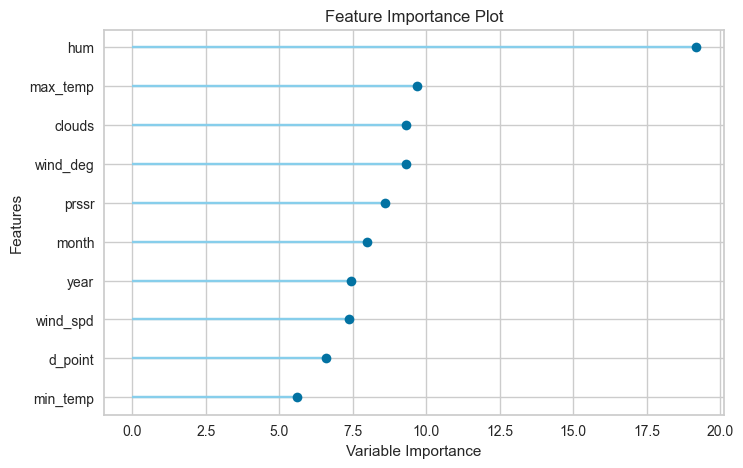

In [33]:
plot_model(tuned_cb, plot="feature")

In [13]:
tuned_cb = load_model("./model/catboost_model_1")

Transformation Pipeline and Model Successfully Loaded


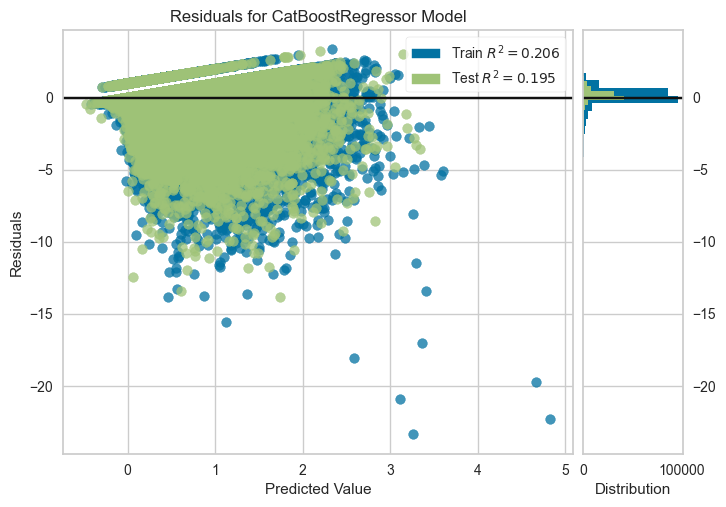

In [14]:
plot_model(tuned_cb, plot="residuals")

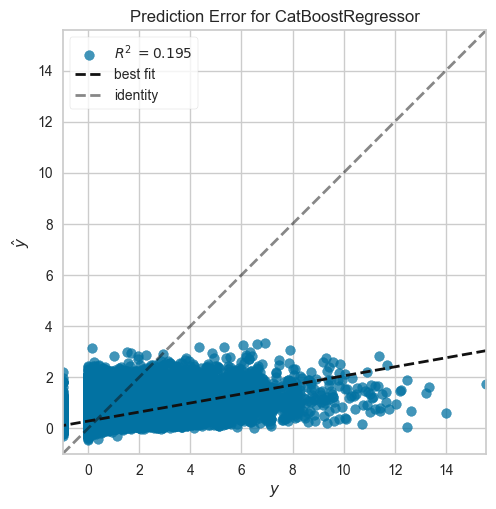

In [15]:
plot_model(tuned_cb, plot="error")

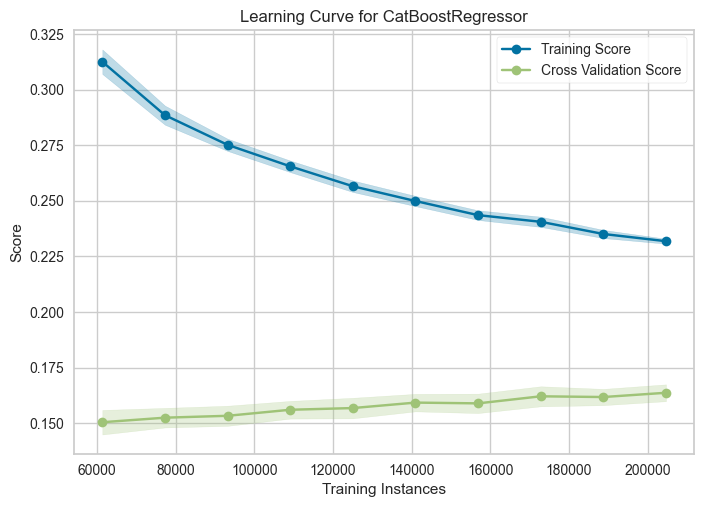

In [16]:
plot_model(tuned_cb, plot="learning")